In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt
import sys
import time
import pdb

from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt


def mean_value_bp(values, alphabet_size, strategy="uniform"):
	if strategy == "uniform":
		values_min = np.min(values)
		values_max = np.max(values)
		return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]
	elif strategy == "normal":
		return norm.ppf(np.linspace(0, 1, alphabet_size+1)[1:-1], np.mean(values), np.std(values))

		
def slope_bp(alphabet_size):
	values_min = -np.pi/4
	values_max = np.pi/4
	return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]


class BagOfPattern(object):
	def __init__(self, alphabet_size_unit, feature_length, feature_type="trend_value",
		global_break_points=False, bp_strategy="uniform"):
		self.feature_type = feature_type
		self.feature_length = feature_length
		self.alph_unit = alphabet_size_unit
		self.alph_size = self._get_alph_size(alphabet_size_unit)
		self.bop_size = self.get_bop_size()
		self.global_break_points = global_break_points
		self.bp_strategy = bp_strategy

	def get_bop_size(self):
		return self.alph_size ** self.feature_length

	def _get_alph_size(self, alph_size_unit):
		if self.feature_type == "trend_value":
			return alph_size_unit * alph_size_unit + 1
		elif self.feature_type == "mean":
			return alph_size_unit


	def _mean_value_char(self, i, j, break_points):
		mean = np.mean(self.observations[i:j])
		character_idx = np.digitize(mean, break_points)
		return character_idx

	def _trend_value_char(self, i, j, break_points):
		value = np.mean(self.observations[i:j])
		slope, _,_,_,_ = linregress(self.time_stamp[i:j], self.observations[i:j])
		trend = np.arctan(slope)
		value_char_idx = np.digitize(value, break_points[0])
		slope_char_idx = np.digitize(slope, break_points[1])
		return slope_char_idx, value_char_idx

	def get_break_points(self, observations, i, j):
		if self.feature_type == "trend_value":
			if self.global_break_points:
				v_bp = mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
			else:
				v_bp = mean_value_bp(observations[i:j], self.alph_unit)
			s_bp = slope_bp(self.alph_unit)
			return [s_bp, v_bp]
		elif self.feature_type == "mean":
			if self.global_break_points:
				return mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
			else:
				return mean_value_bp(observations[i:j], self.alph_unit)

	def get_min_limit(self, tol):
		return self.feature_length * tol

	def segment_to_char(self, obs, times, break_points):
		if self.feature_type == "trend_value":
			mean = np.mean(obs)
			slope, _,_,_,_ = linregress(obs, times)
			trend = np.arctan(slope)
			value_char_idx = np.digitize(mean, break_points[0])
			trend_char_idx = np.digitize(trend, break_points[1])
			return value_char_idx + self.alph_unit * trend_char_idx

		elif self.feature_type == "mean":
			mean = np.mean(obs)
			return np.digitize(mean, break_points)

	def sequence_to_word(self, i, j, ini_time, end_time, observations, time_stamp):
		char_windows = np.linspace(ini_time, end_time, 
					self.feature_length+1)[1:-1]
		break_points = self.get_break_points(observations, i, j)

		sub_obs = observations[i:j]
		sub_times = time_stamp[i:j]

		segments = np.digitize(sub_times, char_windows)

		word_idx = 0
		for k in range(self.feature_length):
			idxs = np.where(k == segments)[0]
			if len(idxs) > 1:
				sub_sub_obs = sub_obs[idxs]
				sub_sub_times = sub_times[idxs]
				val = self.segment_to_char(sub_sub_obs, sub_sub_times, break_points)
			else:
				val = self.alph_size - 1

			word_idx += (self.alph_size ** k) * val
		return word_idx


	def transform_fixed_step(self, observations, time_stamp, window, time_step, tol = 2):
		i = 0
		j = 1
		n = observations.size
		ini_time = time_stamp[0]
		end_time = ini_time + window
		bop = np.zeros(self.bop_size)
		pword_idx = -1
		while ini_time < time_stamp[-1]:
			while time_stamp[i] < ini_time:
				i += 1
			while time_stamp[j] <= end_time:
				if j == n-1:
					break
				j += 1

			if j - i > self.get_min_limit(tol):
				wordp_idx = self.sequence_to_word(i, j, ini_time, end_time,
					observations, time_stamp)
				if wordp_idx != pword_idx:
					bop[wordp_idx] += 1
					pword_idx = wordp_idx
			# else:
				# print("range: ", i, j, ini_time, end_time, "cannot be transformed")
			ini_time += time_step
			end_time += time_step

		return bop



class ExtendedBOPBase(object):
	def __init__(self, alph_unit, word_length, feature_type="mean", global_break_points=False,
		bp_strategy="uniform", tol=2):
		if isinstance(word_length, int):
			word_length = np.array([word_length])
		elif isinstance(word_length, list):
			word_length = np.array(word_length)

		self.alph_unit = alph_unit
		self.feature_type = feature_type
		self.global_break_points = global_break_points
		self.bp_strategy = bp_strategy
		self.word_length = word_length
		self.tol = tol
		self.alph_size = self.get_alph_size()
		self.bop_size = self.get_bop_size()
		self.pword = -1

	def get_alph_size(self):
		if self.feature_type == "trend_value":
			return self.alph_unit * self.alph_unit + 1
		elif self.feature_type == "mean":
			return self.alph_unit + 1

	def get_bop_size(self):
		return np.sum(self.alph_size ** self.word_length)

	def get_break_points(self, observations):
		if self.feature_type == "mean":
			v_bp = mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
			return [v_bp]
		elif self.feature_type == "trend_value":
			v_bp = mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
			s_bp = slope_bp(self.alph_unit)
			return [v_bp, s_bp]

	def segment_to_char(observations, time_stamps, i, j, break_points):
		if self.feature_type == "mean":
			mean = np.mean(observations[i:j])
			return np.digitize(mean, break_points[0])
		elif self.feature_type == "trend_value":
			mean = np.mean(observations[i:j])
			slope, _,_,_,_ = linregress(observations[i:j], time_stamps[i:j])
			trend = np.arctan(slope)
			idx1 = np.digitize(mean, break_points[0])
			idx2 = np.digitize(trend, break_points[1])
			return idx1 + self.alph_unit * idx2
		else:
			raise ValueError("feature type '%s' unknown" % self.feature_type)


	def sequence_to_word(self, observations, time_stamps, i, j, ini_time, end_time, break_points):
		bop_offset = 0
		words_idxs = []
		words_valid = []
		for i in range(len(self.word_length)):
			wl = self.word_length[i]
			char_invalids = 0
			if wl > 1:
				seg_limits = np.linspace(ini_time, end_time, wl + 1)[1:-1]
				segments = np.digitize(time_stamps[i:j], seg_limits)

				wordp = 0
				char_ini = 0
				for k in range(wl):
					char_end = np.argmax(segments[char_ini:] > k)
					if char_end > self.tol:
						char_end += char_ini
						val = self.segment_to_char(observations, time_stamps, char_ini, char_end, break_points)
					else:
						char_invalids += 1
						val = self.alph_size - 1
					wordp += (self.alph_size ** k) * val

			else:
				if j - i > self.tol:
					char = self.segment_to_char(observations, time_stamps, i, j, break_points)
				else:
					char_invalids += 1
					char = self.alph_size - 1
				wordp = char
			words_valid.append(char_invalids <= min(wl // 2, 2))
			words_idxs.append(bop_offset + wordp)
			bop_offset += self.alph_size ** wl
		return words_idxs, words_valid

	def segment_to_char(self, observations, time_stamps, i, j, break_points):
		if self.feature_type == "mean":
			mean = np.mean(observations[i:j])
			return np.digitize(mean, break_points[0])
		elif self.feature_type == "trend_value":
			mean = np.mean(observations[i:j])
			slope, _,_,_,_ = linregress(observations[i:j], time_stamps[i:j])
			trend = np.arctan(slope)
			idx1 = np.digitize(mean, break_points[0])
			idx2 = np.digitize(trend, break_points[1])
			return idx1 + self.alph_unit * idx2
		else:
			raise ValueError("feature type '%s' unknown" % self.feature_type)


class MultiWordBOP(ExtendedBOPBase):

	def transform_fixed_step(self, observations, time_stamps, window, window_step):
		bop = np.zeros(self.bop_size)
		i = 0
		j = 1
		n = observations.size
		min_tol = np.min(self.word_length) * self.tol
		ini_obs = time_stamps[0]
		end_obs = time_stamps[n-1]
		n_segments = int(np.ceil(((end_obs - ini_obs) - window) / window_step))
		break_points = None
		if self.global_break_points:
			break_points = self.get_break_points(observations)
		for k in range(n_segments):
			ini_time = ini_obs + k*window_step
			end_time = ini_time + window
			i2 = np.argmax(time_stamps[i:] >= ini_time)
			j2 = np.argmax(time_stamps[j:] > end_time)
			i += i2
			j += j2
			if (i2 != 0 or j2 != 0) and j - i > min_tol:
				if break_points is None:
					break_points = self.get_break_points(observations[i:j])
				word_idxs = self.sequence_to_word(observations, time_stamps, i, j, ini_time, end_time, break_points)
				for word_idx in word_idxs:
					bop[word_idx] += 1
		return bop

class MultiWindowBOP(ExtendedBOPBase):

	def transform_fixed_step(self, observations, time_stamps, windows, windows_step):
		bop = np.zeros(self.bop_size * len(windows))
		offset = 0
		for window, window_step in zip(windows, windows_step):
			i = 0
			j = 1
			n = observations.size
			ini_obs = time_stamps[0]
			end_obs = time_stamps[n-1]
			n_segments = int(np.ceil((end_obs - ini_obs) - window) / window_step)
			break_points = None
			if self.global_break_points:
				break_points = self.get_break_points(observations)
			for k in range(n_segments):
				ini_time = ini_obs + k*window_step
				end_time = ini_time + window
				i2 = np.argmax(time_stamps[i:] >= ini_time)
				j2 = np.argmax(time_stamps[j:] > end_time)
				i += i2
				j += j2
				if (i2 != 0 or j2 != 0) and j - i > self.tol * self.word_length[0]:
					if not self.global_break_points:
						break_points = self.get_break_points(observations[i:j])
					word_idx = self.sequence_to_word(observations, time_stamps, i, j, ini_time, end_time, break_points)
					bop[word_idx[0] + offset] += 1
			offset += self.bop_size
		return bop

	def transform_all_subsequence(self, observations, time_stamps, windows):
		bop = np.zeros(self.bop_size * len(windows))
		pword = [-1] * len(self.word_length)
		offset = 0
		for window, window_step in zip(windows, windows_step):
			i = 0
			j = 1
			n = observations.size
			ini_obs = time_stamps[0]
			end_obs = time_stamps[n-1]
			break_points = None
			if self.global_break_points:
				break_points = self.get_break_points(observations)
			while i < n - self.tol and time_stamps[i] < end_obs:
				ini_time = time_stamps[i]
				end_time = ini_time + window
				while time_stamps[j] < end_time:
					if j == n-1:
						break
					j += 1
				if j - i > self.tol * self.word_length[0]:
					if break_points is None:
						break_points = self.get_break_points(observations[i:j])
					word_idx, words_valid = self.sequence_to_word(observations, time_stamps, i, j, ini_time, end_time, break_points)
					for k in range(len(word_idx)):
						if words_valid[k]:
							if pword[k] != word_idx[k]:
								bop[word_idx[k] + offset] += 1
								pword[k] = word_idx[k]
				i += 1
			offset += self.bop_size
		return bop


class MultiFeatureBOP(object):
	def __init__(self, alph_unit, word_length, features=["mean"], global_break_points=False,
		bp_strategy="uniform", tol=2):
		if isinstance(word_length, int):
			word_length = np.array([word_length])
		elif isinstance(word_length, list):
			word_length = np.array(word_length)

		self.alph_unit = alph_unit
		self.features = features
		self.global_break_points = global_break_points
		self.bp_strategy = bp_strategy
		self.word_length = word_length
		self.tol = tol
		self.alph_size = self.get_alph_size()
		self.bop_size = self.get_bop_size()
		self.pword = -1

	def get_alph_size(self):
		return (self.alph_unit + 1) * len(self.features)

	def get_bop_size(self):
		return np.sum(self.alph_size ** self.word_length) * len(self.features)

	def segment_to_char(observations, time_stamps, i, j, break_points, feature):
		if feature == "mean":
			mean = np.mean(observations[i:j])
			return np.digitize(mean, break_points)
		elif feature == "trend":
			slope, _,_,_,_ = linregress(observations[i:j], time_stamps[i:j])
			trend = np.arctan(slope)
			return np.digitize(trend, break_points)
		else:
			raise ValueError("feature type '%s' unknown" % self.feature_type)

	def sequence_to_word(self, observations, time_stamps, i, j, ini_time, end_time, break_points):
		bop_offset = 0
		words_idxs = []
		words_valid = []
		for i in range(len(self.word_length)):
			wl = self.word_length[i]
			char_invalids = 0
			if wl > 1:
				seg_limits = np.linspace(ini_time, end_time, wl + 1)[1:-1]
				segments = np.digitize(time_stamps[i:j], seg_limits)

				wordp = 0
				char_ini = 0
				for k in range(wl):
					char_end = np.argmax(segments[char_ini:] > k)
					if char_end > self.tol:
						char_end += char_ini
						val = self.segment_to_char(observations, time_stamps, char_ini, char_end, break_points)
					else:
						char_invalids += 1
						val = self.alph_size - 1
					wordp += (self.alph_size ** k) * val

			else:
				if j - i > self.tol:
					char = self.segment_to_char(observations, time_stamps, i, j, break_points)
				else:
					char_invalids += 1
					char = self.alph_size - 1
				wordp = char
			words_valid.append(char_invalids <= wd // 2 if wd > 2 else 0)
			words_idxs.append(bop_offset + wordp)
			bop_offset += self.alph_size ** wl
		return words_idxs, words_valid


	def transform_all_subsequence(self, observations, time_stamps, windows):
		bop = np.zeros(self.bop_size * len(windows))
		pword = [-1] * len(self.word_length)
		offset = 0
		for window, window_step in zip(windows, windows_step):
			i = 0
			j = 1
			n = observations.size
			ini_obs = time_stamps[0]
			end_obs = time_stamps[n-1]
			break_points = None
			if self.global_break_points:
				break_points = self.get_break_points(observations)
			while i < n - self.tol and time_stamps[i] < end_obs:
				ini_time = time_stamps[i]
				end_time = ini_time + window
				while time_stamps[j] < end_time:
					if j == n-1:
						break
					j += 1
				if j - i > self.tol * self.word_length[0]:
					if break_points is None:
						break_points = self.get_break_points(observations[i:j])
					word_idx, words_valid = self.sequence_to_word(observations, time_stamps, i, j, ini_time, end_time, break_points)
					for k in range(len(word_idx)):
						if words_valid[k]:
							if pword[k] != word_idx[k]:
								bop[word_idx[k] + offset] += 1
								pword[k] = word_idx[k]
				i += 1
			offset += self.bop_size
		return bop

In [3]:
def load_numpy_dataset(data_path, file_base):
    dataset = np.load(os.path.join(data_path, file_base % "d"), allow_pickle=True)
    for i in range(dataset.size):
        dataset[i] = preprocessing.scale(dataset[i])
    times = np.load(os.path.join(data_path, file_base % "t"), allow_pickle=True)
    labels = np.load(os.path.join(data_path, file_base % "l"), allow_pickle=True)
    return dataset, times, labels.astype(int), len(dataset)

def predict_class_cosine(similarity_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmax = -np.inf
        label = -1
        for i in range(n_train):
            if similarity_matrix[i][j] > dmax:
                dmax = similarity_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

def predict_class_euclidean(similairty_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmin = np.inf
        label = -1
        for i in range(n_train):
            if similairty_matrix[i][j] < dmin:
                dmin = similairty_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

In [4]:
def dataset_to_bop(d, t, n, bop_transformer, windows, windows_step, bop_size):
    dataset_repr = np.zeros((n, bop_size))
    count_bads = 0
    for i in range(n):
        obs = d[i]
        time_stamps = t[i]
        if isinstance(obs, list):
            obs = np.array(obs)
        if isinstance(time_stamps, list):
            time_stamps = np.array(time_stamps)
        ts_bop_repr = bop_transformer.transform_fixed_step(obs, time_stamps, windows, windows_step)
        if not np.any(ts_bop_repr):
#             print("time series number ", i, "cannot be represented")
            count_bads += 1
        dataset_repr[i] = ts_bop_repr
    return dataset_repr, count_bads

def dataset_to_bop2(d, t, n, bop_transformer, windows, bop_size):
    dataset_repr = np.zeros((n, bop_size))
    count_bads = 0
    for i in range(n):
        obs = d[i]
        time_stamps = t[i]
        if isinstance(obs, list):
            obs = np.array(obs)
        if isinstance(time_stamps, list):
            time_stamps = np.array(time_stamps)
        ts_bop_repr = bop_transformer.transform_all_subsequence(obs, time_stamps, windows)
        if not np.any(ts_bop_repr):
#             print("time series number ", i, "cannot be represented")
            count_bads += 1
        dataset_repr[i] = ts_bop_repr
    return dataset_repr, count_bads

In [5]:
%%time
main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
key = "ddf"
train_base = key + "_train_%s.npy"
test_base = key + "_test_%s.npy"
d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)

CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 197 ms


In [6]:
alph_unit = 8
n_components = 50
feature_type="mean"
global_break_points=False
bp_strategy="uniform"
with_mean = False
tol=3

In [7]:
%%time
# multi window
windows = [800, 400, 200]
print(windows)
windows_step = [25]*len(windows)
word_length = 1
def multi_window_bop_pipeline(windows, windows_step, word_length, dim_reduction=True, scale=True):
    multi_window_bop = MultiWindowBOP(alph_unit, word_length, feature_type=feature_type,
                                     global_break_points=global_break_points,
                                     bp_strategy=bp_strategy, tol=tol)
    bop_size = multi_window_bop.bop_size * len(windows)
    mwin_bop_repr_train, count_bads_train = dataset_to_bop2(d_train, t_train, n_train, multi_window_bop, 
                                              windows, bop_size)
    print("train repr matrix shape:", mwin_bop_repr_train.shape, ", bads: ", count_bads_train)
    mwin_bop_repr_train = csr_matrix(mwin_bop_repr_train)
    mwin_bop_repr_test, count_bads_test = dataset_to_bop2(d_test, t_test, n_test, multi_window_bop, 
                                              windows, bop_size)
    print("test repr matrix shape:", mwin_bop_repr_test.shape, ", bas: ", count_bads_test)
    dim_before = mwin_bop_repr_test.shape
    mwin_bop_repr_test = csr_matrix(mwin_bop_repr_test)
    
    if scale:
        std_scaler = StandardScaler(with_mean=with_mean)
        mwin_bop_repr_train = std_scaler.fit_transform(mwin_bop_repr_train)
        mwin_bop_repr_test = std_scaler.transform(mwin_bop_repr_test)
        print("scaled vectors")
        

    
    if dim_reduction:
        n_com = min(n_components, dim_before[0], dim_before[1] - 1)
        # print(n_com)
        pca = TruncatedSVD(n_components=n_com, n_iter=20)
#         pca = PCA(n_components=n_com)
        mwin_bop_repr_train = pca.fit_transform(mwin_bop_repr_train)
        mwin_bop_repr_test = pca.transform(mwin_bop_repr_test)
        print("dimensionality reduced from ", dim_before[1], "to", mwin_bop_repr_train.shape[1])
        
    # compute class centroid
    classes = np.unique(l_train)
    n_classes = len(classes)
    classes_vectors = np.zeros((n_classes, mwin_bop_repr_train.shape[1]))
    for i, c in enumerate(classes):
        idxs = np.where(c == l_train)[0]
        for j in idxs:
            classes_vectors[i] += mwin_bop_repr_train[j]
        classes_vectors[i] /= len(idxs)
        

    cos_dmatrix = cosine_similarity(mwin_bop_repr_train, mwin_bop_repr_test)
    euc_dmatrix = euclidean_distances(mwin_bop_repr_train, mwin_bop_repr_test)
    
    cos_classes_dmatrix = cosine_similarity(classes_vectors, mwin_bop_repr_test)
    euc_classes_dmatrix = euclidean_distances(classes_vectors, mwin_bop_repr_test)

    cos_pred = predict_class_cosine(cos_dmatrix, l_train, n_train, n_test)
    euc_pred = predict_class_euclidean(euc_dmatrix, l_train, n_train, n_test)
    
    cos_classes_pred = predict_class_cosine(cos_classes_dmatrix, classes, n_classes, n_test)
    euc_classes_pred = predict_class_euclidean(euc_classes_dmatrix, classes, n_classes, n_test)
    
    cos_acc = balanced_accuracy_score(l_test, cos_pred)
    euc_acc = balanced_accuracy_score(l_test, euc_pred)
    
    cos_classes_acc = balanced_accuracy_score(l_test, cos_classes_pred)
    euc_classes_acc = balanced_accuracy_score(l_test, euc_classes_pred)
    print("cosine similarity balanced classification accuracy: ", cos_acc)
    print("euclidean distance balanced classification accuracy: ", euc_acc)
    print("cosine centroid vectors balanced classification accuracy: ", cos_classes_acc)
    print("euclidean centroid vectors balanced classification accuracy: ", euc_classes_acc)

multi_window_bop_pipeline(windows, windows_step, word_length, dim_reduction=True, scale=True)

[800, 400, 200]
train repr matrix shape: (338, 27) , bads:  0
test repr matrix shape: (225, 27) , bas:  0
scaled vectors
dimensionality reduced from  27 to 26
cosine similarity balanced classification accuracy:  0.5693252399774138
euclidean distance balanced classification accuracy:  0.5676352632874372
cosine centroid vectors balanced classification accuracy:  0.6466573281790673
euclidean centroid vectors balanced classification accuracy:  0.6570092950527733
CPU times: user 2.61 s, sys: 1.06 s, total: 3.67 s
Wall time: 2.03 s


In [144]:
def get_classes_vectors(l_train, mwin_bop_repr_train):
    classes = np.unique(l_train)
    n_classes = len(classes)
    classes_vectors = np.zeros((n_classes, mwin_bop_repr_train.shape[1]))
    for i, c in enumerate(classes):
        idxs = np.where(c == l_train)[0]
        for j in idxs:
            classes_vectors[i] += mwin_bop_repr_train[j]
        classes_vectors[i] /= len(idxs)
    return classes, n_classes, classes_vectors

def get_tf_idf_class(l_train, mwin_bop_repr_train):
    classes = np.unique(l_train)
    n_classes = len(classes)
    classes_vectors = np.zeros((n_classes, mwin_bop_repr_train.shape[1]))
    
    
def reduce_dimension(n_components, dim_before, mwin_bop_repr_train, mwin_bop_repr_test,
                    l_train, n_train, l_test, n_test, scale=True):
    
    tf_idf = TfidfTransformer()
    
    mwin_bop_repr_train_tf_idf = tf_idf.fit_transform(mwin_bop_repr_train)
    mwin_bop_repr_test_tf_idf = tf_idf.transform(mwin_bop_repr_test)
    
    if scale:
        std_scaler = StandardScaler(with_mean=with_mean)
        mwin_bop_repr_train = std_scaler.fit_transform(mwin_bop_repr_train)
        mwin_bop_repr_test = std_scaler.transform(mwin_bop_repr_test)
        std_scaler2 = StandardScaler(with_mean=with_mean)
        mwin_bop_repr_train_tf_idf = std_scaler2.fit_transform(mwin_bop_repr_train_tf_idf)
        mwin_bop_repr_test_tf_idf = std_scaler2.transform(mwin_bop_repr_test_tf_idf)
        print("scaled vectors")
        
    n_com = min(n_components, dim_before[0], dim_before[1] - 1)
    print("we will reduce dimension from ", dim_before[1], "to", n_com)
    cos_dm_arr = []
    euc_dm_arr = []
    cos_c_dm_arr = []
    euc_c_dm_arr = []
    cos_tf_idf_arr = []
    euc_tf_idf_arr = []
    for i in range(10):
    # print(n_com)
        pca = TruncatedSVD(n_components=n_com, n_iter=20)
#         pca = PCA(n_components=n_com)
        mwin_bop_repr_train2 = pca.fit_transform(mwin_bop_repr_train)
        mwin_bop_repr_test2 = pca.transform(mwin_bop_repr_test)
        
        pca2 = TruncatedSVD(n_components=n_com, n_iter=20)
        mwin_bop_repr_train_tf_idf2 = pca2.fit_transform(mwin_bop_repr_train_tf_idf)
        mwin_bop_repr_test_tf_idf2 = pca2.transform(mwin_bop_repr_test_tf_idf)
        
        classes, n_classes, classes_vectors = get_classes_vectors(l_train, mwin_bop_repr_train2)
        
        cos_dmatrix = cosine_similarity(mwin_bop_repr_train2, mwin_bop_repr_test2)
        euc_dmatrix = euclidean_distances(mwin_bop_repr_train2, mwin_bop_repr_test2)
    
        cos_classes_dmatrix = cosine_similarity(classes_vectors, mwin_bop_repr_test2)
        euc_classes_dmatrix = euclidean_distances(classes_vectors, mwin_bop_repr_test2)
        
        cos_dmatrix_tf_idf = cosine_similarity(mwin_bop_repr_train_tf_idf2, mwin_bop_repr_test_tf_idf2)
        euc_dmatrix_tf_idf = euclidean_distances(mwin_bop_repr_train_tf_idf2, mwin_bop_repr_test_tf_idf2)

        
        cos_pred = predict_class_cosine(cos_dmatrix, l_train, n_train, n_test)
        euc_pred = predict_class_euclidean(euc_dmatrix, l_train, n_train, n_test)
    
        cos_classes_pred = predict_class_cosine(cos_classes_dmatrix, classes, n_classes, n_test)
        euc_classes_pred = predict_class_euclidean(euc_classes_dmatrix, classes, n_classes, n_test)
        
        cos_pred_tf_idf = predict_class_cosine(cos_dmatrix_tf_idf, l_train, n_train, n_test)
        euc_pred_tf_idf = predict_class_euclidean(euc_dmatrix_tf_idf, l_train, n_train, n_test)
    
    
        cos_acc = balanced_accuracy_score(l_test, cos_pred)
        euc_acc = balanced_accuracy_score(l_test, euc_pred)
    
        cos_classes_acc = balanced_accuracy_score(l_test, cos_classes_pred)
        euc_classes_acc = balanced_accuracy_score(l_test, euc_classes_pred)
        
        cos_acc_tf_idf = balanced_accuracy_score(l_test, cos_pred_tf_idf)
        euc_acc_tf_idf = balanced_accuracy_score(l_test, euc_pred_tf_idf)
        
        
        cos_dm_arr.append(cos_acc)
        euc_dm_arr.append(euc_acc)
        cos_c_dm_arr.append(cos_classes_acc)
        euc_c_dm_arr.append(euc_classes_acc)
        cos_tf_idf_arr.append(cos_acc_tf_idf)
        euc_tf_idf_arr.append(euc_acc_tf_idf)
    r = []
    r.append(round(np.mean(cos_dm_arr), 3))
    r.append(round(np.std(cos_dm_arr), 3))
    r.append(round(np.mean(cos_c_dm_arr), 3))
    r.append(round(np.std(cos_c_dm_arr), 3))
    r.append(round(np.mean(euc_dm_arr), 3))
    r.append(round(np.std(euc_dm_arr), 3))
    r.append(round(np.mean(euc_c_dm_arr), 3))
    r.append(round(np.std(euc_c_dm_arr), 3))
    r.append(round(np.mean(cos_tf_idf_arr), 3))
    r.append(round(np.std(cos_tf_idf_arr), 3))
    r.append(round(np.mean(euc_tf_idf_arr), 3))
    r.append(round(np.std(euc_tf_idf_arr), 3))
    
    print("cosine similarity, classification, balanced accuracy:" + 
          "%f +- %f" % (round(np.mean(cos_dm_arr), 3), round(np.std(cos_dm_arr), 3)))
    print("euclidean distance, classification, balanced accuracy:" + 
          "%f +- %f" % (round(np.mean(euc_dm_arr), 3), round(np.std(euc_dm_arr), 3)))
    print("cosine similarity classes, classification, balanced accuracy:" + 
          "%f +- %f" % (round(np.mean(cos_c_dm_arr), 3), round(np.std(cos_c_dm_arr), 3)))
    print("euclidean distance, classification, balanced accuracy:" + 
          "%f +- %f" % (round(np.mean(euc_c_dm_arr), 3), round(np.std(euc_c_dm_arr), 3)))
    print("cosine similarity tf-idf, classification, balanced accuracy:" + 
          "%f +- %f" % (round(np.mean(cos_tf_idf_arr), 3), round(np.std(cos_tf_idf_arr), 3)))
    print("euclidean distance tf_idf, classification, balanced accuracy:" + 
          "%f +- %f" % (round(np.mean(euc_tf_idf_arr), 3), round(np.std(euc_tf_idf_arr), 3)))
#     print(r)
    return r
    

def mwindow_bop_pca_pipeline(windows, windows_step, word_length, scale=True):
    multi_window_bop = MultiWindowBOP(alph_unit, word_length, feature_type=feature_type,
                                     global_break_points=global_break_points,
                                     bp_strategy=bp_strategy, tol=tol)
    bop_size = multi_window_bop.bop_size * len(windows)
    mwin_bop_repr_train, count_bads_train = dataset_to_bop2(d_train, t_train, n_train, multi_window_bop, 
                                              windows, bop_size)
    print("train repr matrix shape:", mwin_bop_repr_train.shape, ", bads: ", count_bads_train)
    mwin_bop_repr_train = csr_matrix(mwin_bop_repr_train)
    mwin_bop_repr_test, count_bads_test = dataset_to_bop2(d_test, t_test, n_test, multi_window_bop, 
                                              windows, bop_size)
    print("test repr matrix shape:", mwin_bop_repr_test.shape, ", bads: ", count_bads_test)
    dim_before = [min(len(d_train), len(d_test)), bop_size]
    mwin_bop_repr_test = csr_matrix(mwin_bop_repr_test)
        
    r = reduce_dimension(n_components, dim_before, mwin_bop_repr_train, mwin_bop_repr_test,
                    l_train, n_train, l_test, n_test, scale=scale)
    return r

In [145]:
keys = ["cos1_acc_mean", "cos1_acc_std", "cos2_acc_mean", "cos2_acc_std", 
        "euc1_acc_mean", "euc1_acc_std", "euc2_acc_mean", "euc2_acc_std", 
        "cos_tf_idf_acc_mean", "cos_tf_idf_acc_std", "euc_tf_idf_acc_mean", "euc_tf_idf_acc_std"]
results = defaultdict(list)
wls = [1, 2, 3, 4, 5, 6]
windows = [800, 400, 200]
windows_step = [25] * len(windows)
for wl in wls:
    print("word length:", wl)
    r = mwindow_bop_pca_pipeline(windows, windows_step, wl, scale=True)
#     print(r)
    for r_i, k in zip(r, keys):
        results[k].append(r_i)

word length: 1
train repr matrix shape: (338, 27) , bads:  0
test repr matrix shape: (225, 27) , bas:  0
scaled vectors
we will reduce dimension from  27 to 26
cosine similarity, classification, balanced accuracy:0.569000 +- 0.002000
euclidean distance, classification, balanced accuracy:0.567000 +- 0.001000
cosine similarity classes, classification, balanced accuracy:0.647000 +- 0.000000
euclidean distance, classification, balanced accuracy:0.657000 +- 0.000000
cosine similarity tf-idf, classification, balanced accuracy:0.534000 +- 0.002000
euclidean distance tf_idf, classification, balanced accuracy:0.542000 +- 0.001000
word length: 2
train repr matrix shape: (338, 243) , bads:  0
test repr matrix shape: (225, 243) , bas:  0
scaled vectors
we will reduce dimension from  243 to 50
cosine similarity, classification, balanced accuracy:0.502000 +- 0.007000
euclidean distance, classification, balanced accuracy:0.521000 +- 0.007000
cosine similarity classes, classification, balanced accurac

KeyboardInterrupt: 

Text(0, 0.5, 'balanced accuracy')

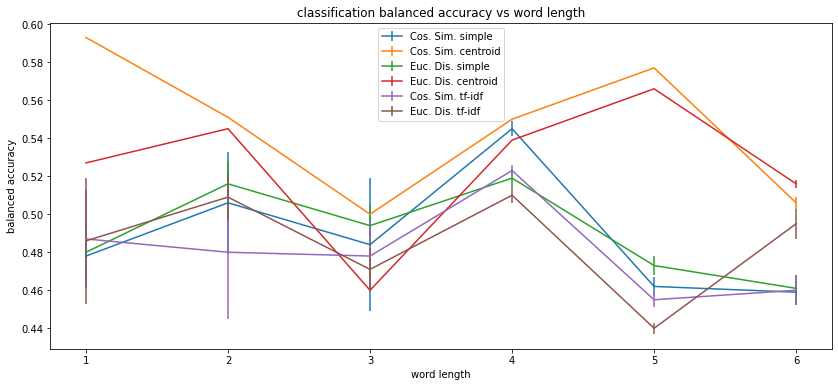

In [125]:
plt.figure(figsize=(14, 6))
plt.errorbar(wls, results["cos1_acc_mean"], yerr=results["cos1_acc_std"], label="Cos. Sim. simple")
plt.errorbar(wls, results["cos2_acc_mean"], yerr=results["cos2_acc_std"], label="Cos. Sim. centroid")
plt.errorbar(wls, results["euc1_acc_mean"], yerr=results["euc1_acc_std"], label="Euc. Dis. simple")
plt.errorbar(wls, results["euc2_acc_mean"], yerr=results["euc2_acc_std"], label="Euc. Dis. centroid")
plt.errorbar(wls, results["cos_tf_idf_acc_mean"], yerr=results["cos_tf_idf_acc_std"], 
             label="Cos. Sim. tf-idf")
plt.errorbar(wls, results["euc_tf_idf_acc_mean"], yerr=results["euc_tf_idf_acc_std"], 
             label="Euc. Dis. tf-idf")
plt.legend()
plt.title("classification balanced accuracy vs word length")
plt.xlabel("word length")
plt.ylabel("balanced accuracy")

In [9]:
%%time
# multi window
windows = 400
windows_step = 20
word_length = [2, 4, 5, 6, 7]
def multi_word_bop_pipeline(windows, windows_step, word_length, dim_reduction=True, scale=True):
    multi_word_bop = MultiWordBOP(alph_unit, word_length, feature_type=feature_type,
                                     global_break_points=global_break_points,
                                     bp_strategy=bp_strategy, tol=tol)
    bop_size = multi_word_bop.bop_size
    mwin_bop_repr_train, count_bads_train = dataset_to_bop(d_train, t_train, n_train, multi_word_bop, 
                                              windows, windows_step, bop_size)
    print("train repr matrix shape:", mwin_bop_repr_train.shape, ", bads: ", count_bads_train)
    mwin_bop_repr_train = csr_matrix(mwin_bop_repr_train)
    mwin_bop_repr_test, count_bads_test = dataset_to_bop(d_test, t_test, n_test, multi_word_bop, 
                                              windows, windows_step, bop_size)
    print("test repr matrix shape:", mwin_bop_repr_test.shape, ", bas: ", count_bads_test)
    dim_before = mwin_bop_repr_test.shape
    mwin_bop_repr_test = csr_matrix(mwin_bop_repr_test)
    
    if scale:
        std_scaler = StandardScaler(with_mean=with_mean)
        mwin_bop_repr_train = std_scaler.fit_transform(mwin_bop_repr_train)
        mwin_bop_repr_test = std_scaler.transform(mwin_bop_repr_test)
        print("scaled vectors")
    
    if dim_reduction:
        n_com = min(n_components, dim_before[0], dim_before[1])
        # print(n_com)
        pca = TruncatedSVD(n_components=n_com, n_iter=10)
        mwin_bop_repr_train = pca.fit_transform(mwin_bop_repr_train)
        mwin_bop_repr_test = pca.transform(mwin_bop_repr_test)
        print("dimensionality reduced from ", dim_before[1], "to", mwin_bop_repr_train.shape[1])
        
    # compute class centroid
    classes = np.unique(l_train)
    n_classes = len(classes)
    classes_vectors = np.zeros((n_classes, mwin_bop_repr_train.shape[1]))
    for i, c in enumerate(classes):
        idxs = np.where(c == l_train)[0]
        for j in idxs:
            classes_vectors[i] += mwin_bop_repr_train[j]
        classes_vectors[i] /= len(idxs)
        

    cos_dmatrix = cosine_similarity(mwin_bop_repr_train, mwin_bop_repr_test)
    euc_dmatrix = euclidean_distances(mwin_bop_repr_train, mwin_bop_repr_test)
    
    cos_classes_dmatrix = cosine_similarity(classes_vectors, mwin_bop_repr_test)
    euc_classes_dmatrix = euclidean_distances(classes_vectors, mwin_bop_repr_test)

    cos_pred = predict_class_cosine(cos_dmatrix, l_train, n_train, n_test)
    euc_pred = predict_class_euclidean(euc_dmatrix, l_train, n_train, n_test)
    
    cos_classes_pred = predict_class_cosine(cos_classes_dmatrix, classes, n_classes, n_test)
    euc_classes_pred = predict_class_euclidean(euc_classes_dmatrix, classes, n_classes, n_test)
    
    cos_acc = balanced_accuracy_score(l_test, cos_pred)
    euc_acc = balanced_accuracy_score(l_test, euc_pred)
    
    cos_classes_acc = balanced_accuracy_score(l_test, cos_classes_pred)
    euc_classes_acc = balanced_accuracy_score(l_test, euc_classes_pred)
    print("cosine similarity balanced classification accuracy: ", cos_acc)
    print("euclidean distance balanced classification accuracy: ", euc_acc)
    print("cosine centroid vectors balanced classification accuracy: ", cos_classes_acc)
    print("euclidean centroid vectors balanced classification accuracy: ", euc_classes_acc)

multi_word_bop_pipeline(windows, windows_step, word_length, dim_reduction=True, scale=False)

train repr matrix shape: (338, 97525) , bads:  0
test repr matrix shape: (225, 97525) , bas:  0
dimensionality reduced from  97525 to 50
cosine similarity balanced classification accuracy:  0.4029195442238921
euclidean distance balanced classification accuracy:  0.4076108673934761
cosine centroid vectors balanced classification accuracy:  0.38288269701313177
euclidean centroid vectors balanced classification accuracy:  0.3916945373467112
CPU times: user 15.3 s, sys: 6.63 s, total: 21.9 s
Wall time: 7.24 s


In [32]:
%debug

> /usr/lib/python3.8/site-packages/numpy/core/fromnumeric.py(61)_wrapfunc()
     59 
     60     try:
---> 61         return bound(*args, **kwds)
     62     except TypeError:
     63         # A TypeError occurs if the object does have such a method in its

ipdb> up
> /usr/lib/python3.8/site-packages/numpy/core/fromnumeric.py(1153)argmax()
   1151 
   1152     """
-> 1153     return _wrapfunc(a, 'argmax', axis=axis, out=out)
   1154 
   1155 

ipdb> up
> <__array_function__ internals>(5)argmax()

ipdb> up
> <ipython-input-2-8934cda5de85>(207)sequence_to_word()
    205                                 char_ini = 0
    206                                 for k in range(wl):
--> 207                                         char_end = np.argmax(segments[char_ini:] > k)
    208                                         if char_end > self.tol:
    209                                                 char_end += char_ini

ipdb> wl
4
ipdb> segments
array([], dtype=int64)
ipdb> seg_limits
array([59

In [29]:
from collections import defaultdict
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt


def mean_value_bp(values, alphabet_size, strategy="uniform"):
# 	pdb.set_trace()
	if strategy == "uniform":
		values_min = np.min(values)
		values_max = np.max(values)
		return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]
	elif strategy == "normal":
# 		print("doing it")        
		return norm.ppf(np.linspace(0, 1, 8+1)[1:-1], np.mean(values), np.std(values))

		
def slope_bp(alphabet_size):
	values_min = -np.pi/4
	values_max = np.pi/4
	return np.linspace(values_min, values_max, alphabet_size+1)[1:-1]


# class BagOfPattern(object):
# 	def __init__(self, alphabet_size_unit, feature_length, feature_type="trend_value",
# 		global_break_points=False, bp_strategy="uniform"):
# 		self.feature_type = feature_type
# 		self.feature_length = feature_length
# 		self.alph_unit = alphabet_size_unit
# 		self.alph_size = self._get_alph_size(alphabet_size_unit)
# 		self.bop_size = self.get_bop_size()
# 		self.global_break_points = global_break_points
# 		self.bp_strategy = bp_strategy

# 	def get_bop_size(self):
# 		return self.alph_size ** self.feature_length

# 	def _get_alph_size(self, alph_size_unit):
# 		if self.feature_type == "trend_value":
# 			return alph_size_unit * alph_size_unit + 1
# 		elif self.feature_type == "mean":
# 			return alph_size_unit


# 	def _mean_value_char(self, i, j, break_points):
# 		mean = np.mean(self.observations[i:j])
# 		character_idx = np.digitize(mean, break_points)
# 		return character_idx

# 	def _trend_value_char(self, i, j, break_points):
# 		value = np.mean(self.observations[i:j])
# 		slope, _,_,_,_ = linregress(self.time_stamp[i:j], self.observations[i:j])
# 		trend = np.arctan(slope)
# 		value_char_idx = np.digitize(value, break_points[0])
# 		slope_char_idx = np.digitize(slope, break_points[1])
# 		return slope_char_idx, value_char_idx

# 	def get_break_points(self, observations, i, j):
# 		if self.feature_type == "trend_value":
# 			if self.global_break_points:
# 				v_bp = mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
# 			else:
# 				v_bp = mean_value_bp(observations[i:j], self.alph_unit)
# 			s_bp = slope_bp(self.alph_unit)
# 			return [s_bp, v_bp]
# 		elif self.feature_type == "mean":
# 			if self.global_break_points:
# 				return mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
# 			else:
# 				return mean_value_bp(observations[i:j], self.alph_unit)

# 	def get_min_limit(self, tol):
# 		return self.feature_length * tol

# 	def segment_to_char(self, obs, times, break_points):
# 		if self.feature_type == "trend_value":
# 			mean = np.mean(obs)
# 			slope, _,_,_,_ = linregress(obs, times)
# 			trend = np.arctan(slope)
# 			value_char_idx = np.digitize(mean, break_points[0])
# 			trend_char_idx = np.digitize(trend, break_points[1])
# 			return value_char_idx + self.alph_unit * trend_char_idx

# 		elif self.feature_type == "mean":
# 			mean = np.mean(obs)
# 			return np.digitize(mean, break_points)

# 	def sequence_to_word(self, i, j, ini_time, end_time, observations, time_stamp):
# 		char_windows = np.linspace(ini_time, end_time, 
# 					self.feature_length+1)[1:-1]
# 		break_points = self.get_break_points(observations, i, j)

# 		sub_obs = observations[i:j]
# 		sub_times = time_stamp[i:j]

# 		segments = np.digitize(sub_times, char_windows)

# 		word_idx = 0
# 		for k in range(self.feature_length):
# 			idxs = np.where(k == segments)[0]
# 			if len(idxs) > 1:
# 				sub_sub_obs = sub_obs[idxs]
# 				sub_sub_times = sub_times[idxs]
# 				val = self.segment_to_char(sub_sub_obs, sub_sub_times, break_points)
# 			else:
# 				val = self.alph_size - 1

# 			word_idx += (self.alph_size ** k) * val
# 		return word_idx


# 	def transform_fixed_step(self, observations, time_stamp, window, time_step, tol = 2):
# 		i = 0
# 		j = 1
# 		n = observations.size
# 		ini_time = time_stamp[0]
# 		end_time = ini_time + window
# 		bop = np.zeros(self.bop_size)
# 		pword_idx = -1
# 		while ini_time < time_stamp[-1]:
# 			while time_stamp[i] < ini_time:
# 				i += 1
# 			while time_stamp[j] <= end_time:
# 				if j == n-1:
# 					break
# 				j += 1

# 			if j - i > self.get_min_limit(tol):
# 				wordp_idx = self.sequence_to_word(i, j, ini_time, end_time,
# 					observations, time_stamp)
# 				if wordp_idx != pword_idx:
# 					bop[wordp_idx] += 1
# 					pword_idx = wordp_idx
# 			# else:
# 				# print("range: ", i, j, ini_time, end_time, "cannot be transformed")
# 			ini_time += time_step
# 			end_time += time_step

# 		return bop


# class MultiResolutionBOP(BagOfPattern):

# 	def __init__(self, alphabet_size_unit, feature_length, feature_type="mean", global_break_points=False,
# 		bp_strategy="uniform"):
# 		self.feature_lengths = np.array(feature_length)
# 		self.feature_type = feature_type
# 		self.feature_length = feature_length
# 		self.alph_unit = alphabet_size_unit
# 		self.alph_size = self._get_alph_size(alphabet_size_unit)
# 		self.bop_size = self.get_bop_size()
# 		self.global_break_points = global_break_points
# 		self.bp_strategy = bp_strategy





# 	def get_bop_size_level(self,level):
# 		return self.alph_size ** self.feature_lengths[level]

# 	def get_bop_size(self):
# 		return np.sum(self.alph_size ** np.array(self.feature_lengths))

# 	def get_min_limit(self, tol):
# 		return tol * np.min(self.feature_lengths)

# 	def transform_fixed_step(self, observations, time_stamp, window, time_step, tol = 2):
# 		i = 0
# 		j = 1
# 		n = observations.size
# 		ini_time = time_stamp[0]
# 		end_time = ini_time + window
# 		bop = np.zeros(self.bop_size)
# 		pword_idx = -1
# 		i_prev = -1
# 		j_prev = -1
# 		while ini_time < time_stamp[-1]:
# 			while time_stamp[i] < ini_time:
# 				i += 1
# 			while time_stamp[j] <= end_time:
# 				if j == n-1:
# 					break
# 				j += 1

# 			if (i != i_prev or j != j_prev) and j - i > self.get_min_limit(tol):
# 				for f_len in self.feature_lengths:
# 					self.feature_length = f_len
# 					wordp_idx = self.sequence_to_word(i, j, ini_time, end_time,
# 													observations, time_stamp)
# 					if wordp_idx != pword_idx:
# 						bop[wordp_idx] += 1
# 						# pword_idx = wordp_idx
# 			ini_time += time_step
# 			end_time += time_step
# 			i_prev = i
# 			j_prev = j

# 		return bop


class SimpleBOP(object):
	def __init__(self, alph_unit, feature_type="mean", global_break_points=False,
		bp_strategy="uniform", tol=2):
		self.alph_unit = alph_unit
		self.feature_type=feature_type
		self.global_break_points=global_break_points
		self.bp_strategy = bp_strategy
		self.alph_size = self._get_alph_size(alph_unit)
		self.bop_size = self.get_bop_size()
		self.tol = tol

	def get_bop_size(self):
		return self.alph_size 

	def _get_alph_size(self, alph_size_unit):
		if self.feature_type == "trend_value":
			return alph_size_unit * alph_size_unit + 1
		elif self.feature_type == "mean":
			return alph_size_unit

	def get_break_points(self, observations):
# 		pdb.set_trace()
		if self.feature_type == "mean":
			v_bp = mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
			return [v_bp]
		elif self.feature_type == "trend_value":
			v_bp = mean_value_bp(observations, self.alph_unit, strategy=self.bp_strategy)
			s_bp = slope_bp(self.alph_unit)
			return [v_bp, s_bp]


	def transform_fixed_step(self, observations, time_stamps, window, window_step):
		i = 0
		j = 1
		n = observations.size
		ini_obs = time_stamps[0]
		end_obs = time_stamps[n-1]
		n_segments = int(np.ceil(((end_obs - ini_obs) - window) / window_step))
		bop = np.zeros(self.bop_size)
		break_points = None
		if self.global_break_points:
			break_points = self.get_break_points(observations)
		for k in range(n_segments):
			ini_time = ini_obs + k*window_step
			end_time = ini_time + window
			i2 = np.argmax(time_stamps[i:] >= ini_time)
			j2 = np.argmax(time_stamps[j:] > end_time)
			i += i2
			j += j2
			if (i2 != 0 or j2 != 0) and j - i > self.tol:
				if break_points is None:
					break_points = self.get_break_points(observations[i:j])
				wordp_idx = self.transform_segment(observations, time_stamps, i, j, break_points)
				bop[wordp_idx] += 1

		return bop

	def transform_segment(self, observations, time_stamps, i, j, break_points):
		if self.feature_type == "mean":
			mean = np.mean(observations[i:j])
			return np.digitize(mean, break_points[0])
		elif self.feature_type == "trend_value":
			mean = np.mean(observations[i:j])
			slope, _,_,_,_ = linregress(observations[i:j], time_stamps[i:j])
			trend = np.arctan(slope)
			idx1 = np.digitize(mean, break_points[0])
			idx2 = np.digitize(trend, break_points[1])
			return idx1 + self.alph_unit * idx2
		else:
			raise ValueError("feature type '%s' unknown" % self.feature_type)








In [3]:
def load_numpy_dataset(data_path, file_base):
    dataset = np.load(os.path.join(data_path, file_base % "d"), allow_pickle=True)
    for i in range(dataset.size):
        dataset[i] = preprocessing.scale(dataset[i])
    times = np.load(os.path.join(data_path, file_base % "t"), allow_pickle=True)
    labels = np.load(os.path.join(data_path, file_base % "l"), allow_pickle=True)
    return dataset, times, labels.astype(int), len(dataset)

In [27]:
def predict_class_cosine(similarity_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmax = -np.inf
        label = -1
        for i in range(n_train):
            if similarity_matrix[i][j] > dmax:
                dmax = similarity_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

def predict_class_euclidean(similairty_matrix, train_label, n_train, n_test):
    pred_labels = []
    for j in range(n_test):
        dmin = np.inf
        label = -1
        for i in range(n_train):
            if similairty_matrix[i][j] < dmin:
                dmin = similairty_matrix[i][j]
                label = train_label[i]
        pred_labels.append(label)
    return pred_labels

In [5]:
def bop_dataset(d, t, n, bop_transformer, window, time_step):
    dataset_repr = np.zeros((n, bop_transformer.bop_size))
    count_bads = 0
    for i in range(n):
        obs = d[i]
        time_stamps = t[i]
        if isinstance(obs, list):
            obs = np.array(obs)
        if isinstance(time_stamps, list):
            time_stamps = np.array(time_stamps)
        ts_bop_repr = bop_transformer.transform_fixed_step(obs, time_stamps, window, time_step)
        if not np.any(ts_bop_repr):
#             print("time series number ", i, "cannot be represented")
            count_bads += 1
        dataset_repr[i] = ts_bop_repr
    print(count_bads, "time series couldn't be represented using BOP")
    return dataset_repr

def bop_dataset_multiresolution(d, t, n, mr_bop_transformer, window, time_step):
    bop_transformers = []
    
    dataset_repr = np.zeros((n, mr_bop_transformer.bop_size))
    print("output matrix shape: ", dataset_repr.shape)
    count_bads = 0
    for i in range(n):
        obs = d[i]
        time_stamps = t[i]
        if isinstance(obs, list):
            obs = np.array(obs)
        if isinstance(time_stamps, list):
            time_stamps = np.array(time_stamps)
        ts_bop_repr = mr_bop_transformer.transform_fixed_step(obs, time_stamps, window, time_step)
        dataset_repr[i] = ts_bop_repr
        if not np.any(ts_bop_repr):
#             print("time series number ", i, "cannot be represented")
            count_bads += 1
    print(count_bads, "time series couldn't be represented using BOP")
    return csr_matrix(dataset_repr)

In [108]:
%%time
main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
key = "ddf"
train_base = key + "_train_%s.npy"
test_base = key + "_test_%s.npy"
d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)

CPU times: user 337 ms, sys: 12.3 ms, total: 349 ms
Wall time: 327 ms


In [99]:
%%time
# arguments
alph_unit = 4
feature_length = 2
feature_type="mean"
global_break_points = False
window = 80
time_step = 20

# transformer class
bop_transformer = BagOfPattern(alph_unit, feature_length, 
                                feature_type=feature_type, global_break_points=global_break_points)
print("bop size:", bop_transformer.bop_size)

bop size: 16
CPU times: user 776 µs, sys: 165 µs, total: 941 µs
Wall time: 735 µs


In [100]:
%%time
## transform train dataset
repr_bop_train = bop_dataset(d_train, t_train, n_train, bop_transformer, window, time_step)

CPU times: user 1.13 s, sys: 52.6 ms, total: 1.18 s
Wall time: 1.15 s


In [101]:
%%time
## transform test dataset
repr_bop_test = bop_dataset(d_test, t_test, n_test, bop_transformer, window, time_step)

CPU times: user 746 ms, sys: 96 ms, total: 842 ms
Wall time: 732 ms


In [102]:
%%time
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(repr_bop_train)

CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 3.16 ms


PCA(n_components=10)

In [103]:
%%time
bop_pca_train = pca.transform(repr_bop_train)

CPU times: user 348 µs, sys: 73 µs, total: 421 µs
Wall time: 425 µs


In [104]:
%%time
bop_pca_test = pca.transform(repr_bop_test)

CPU times: user 389 µs, sys: 81 µs, total: 470 µs
Wall time: 419 µs


In [105]:
%%time
similarity_matrix = cosine_similarity(bop_pca_train, bop_pca_test)

CPU times: user 33.6 ms, sys: 18.7 ms, total: 52.2 ms
Wall time: 9.69 ms


In [106]:
%%time
pred_labels = predict_class(similarity_matrix, l_train, n_train, n_test)

CPU times: user 106 ms, sys: 1.25 ms, total: 107 ms
Wall time: 106 ms


In [107]:
accuracy_score(l_test, pred_labels), balanced_accuracy_score(l_test, pred_labels)

(0.44, 0.3983777092472745)

In [100]:
def search_window(windows, key="ddf", feature_type="mean", global_break_points=False, bp_strategy="uniform"):
    main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
    data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
    train_base = key + "_train_%s.npy"
    test_base = key + "_test_%s.npy"
    d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
    d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)

    alph_unit = 4
    feature_length = 2
#     window = 80
    time_step = 25
    n_components = 10
    
    bop_transformer = BagOfPattern(alph_unit, feature_length, 
                                   feature_type=feature_type, global_break_points=global_break_points,
                                  bp_strategy=bp_strategy)
    mr_bop_transformer = MultiResolutionBOP(alph_unit, [1, 2, 4],
                                           feature_type=feature_type, 
                                            global_break_points=global_break_points, 
                                            bp_strategy=bp_strategy)
    
    accs = []
    baccs = []
    for window in windows:
        
        ini = time.time()
        repr_bop_train = bop_dataset_multiresolution(d_train, t_train, n_train, mr_bop_transformer,
                                                     window, time_step)
        repr_bop_train = StandardScaler(with_mean=False).fit_transform(repr_bop_train)
        repr_bop_test = bop_dataset_multiresolution(d_test, t_test, n_test, mr_bop_transformer,
                                                    window, time_step)
        repr_bop_test = StandardScaler(with_mean=False).fit_transform(repr_bop_test)
        
        
        pca = TruncatedSVD(n_components=n_components)
        pca.fit(repr_bop_train)
        
        bop_pca_train = pca.transform(repr_bop_train)
        bop_pca_test = pca.transform(repr_bop_test)
        similarity_matrix = cosine_similarity(bop_pca_train, bop_pca_test)
        pred_labels = predict_class(similarity_matrix, l_train, n_train, n_test)
        end = time.time()
        acc = accuracy_score(l_test, pred_labels)
        bacc = balanced_accuracy_score(l_test, pred_labels)
        print("acc: %f, bacc: %f, for window: %f, exec. time: %f" % (round(acc, 3), round(bacc, 3), window, round(end-ini, 3)))
        accs.append(acc)
        baccs.append(bacc)
    return accs, baccs

In [101]:
windows = np.arange(4) * 150 + 50
key = "wdf"
feature_type = "mean"
global_break_points = True
bp_strategy="normal"
accs, baccs = search_window(windows, key=key, feature_type=feature_type, 
                            global_break_points=global_break_points, bp_strategy=bp_strategy)

output matrix shape:  (461, 276)
0 time series couldn't be represented using BOP
output matrix shape:  (306, 276)
0 time series couldn't be represented using BOP
acc: 0.415000, bacc: 0.404000, for window: 50.000000, exec. time: 6.921000
output matrix shape:  (461, 276)
0 time series couldn't be represented using BOP
output matrix shape:  (306, 276)
0 time series couldn't be represented using BOP
acc: 0.474000, bacc: 0.459000, for window: 200.000000, exec. time: 15.172000
output matrix shape:  (461, 276)
0 time series couldn't be represented using BOP
output matrix shape:  (306, 276)
0 time series couldn't be represented using BOP
acc: 0.471000, bacc: 0.464000, for window: 350.000000, exec. time: 16.768000
output matrix shape:  (461, 276)
0 time series couldn't be represented using BOP
output matrix shape:  (306, 276)
0 time series couldn't be represented using BOP
acc: 0.441000, bacc: 0.429000, for window: 500.000000, exec. time: 17.912000


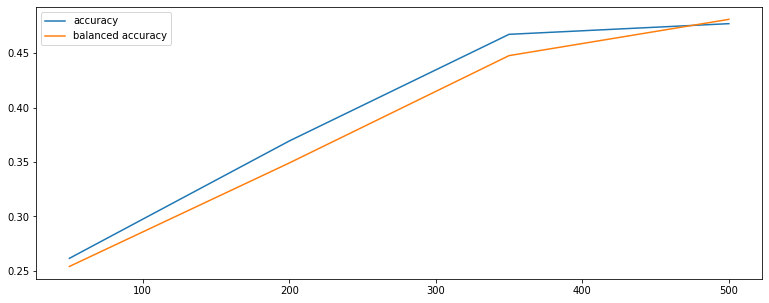

In [98]:
plt.figure(figsize=(13, 5))
plt.plot(windows, accs, label="accuracy")
plt.plot(windows, baccs, label="balanced accuracy")
plt.legend()

In [93]:
def bop_dataset_multires2(d, t, n, bop_transformer, windows, time_step):
    dataset_repr = np.zeros((n, bop_transformer.bop_size* len(windows)))
    count_bads = 0
    for i in range(n):
        obs = d[i]
        time_stamps = t[i]
        if isinstance(obs, list):
            obs = np.array(obs)
        if isinstance(time_stamps, list):
            time_stamps = np.array(time_stamps)
        k = 0
        for window in windows:
            ts_bop_repr = bop_transformer.transform_fixed_step(obs, time_stamps, window, time_step)
            dataset_repr[i][k:k+bop_transformer.bop_size] = ts_bop_repr
            k += bop_transformer.bop_size
        if not np.any(dataset_repr[i]):
#             print("time series number ", i, "cannot be represented")
            count_bads += 1
#         dataset_repr[i] = ts_bop_repr
    print(count_bads, "time series couldn't be represented using BOP")
    return dataset_repr

def search_window2(windows, key="ddf", feature_type="mean", global_break_points=False, bp_strategy="uniform"):
    main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..'))
    data_path = os.path.join(main_path, "data", "plasticc_subsets", "ddf_wdf_split_min_detection", "3_min")
    train_base = key + "_train_%s.npy"
    test_base = key + "_test_%s.npy"
    d_train, t_train, l_train, n_train = load_numpy_dataset(data_path, train_base)
    d_test, t_test, l_test, n_test = load_numpy_dataset(data_path, test_base)

    alph_unit = 8
#     window = 80
    time_step = 20
    n_components = 10
    
    bop_transformer = SimpleBOP(alph_unit, feature_type=feature_type, 
                                global_break_points=global_break_points, bp_strategy=bp_strategy)
    
    repr_bop_train = bop_dataset_multires2(d_train, t_train, n_train, bop_transformer,
                                                     windows, time_step)
    repr_bop_test = bop_dataset_multires2(d_test, t_test, n_test, bop_transformer,
                                                    windows, time_step)
    repr_bop_train = StandardScaler(with_mean=True).fit_transform(repr_bop_train)
    repr_bop_test = StandardScaler(with_mean=True).fit_transform(repr_bop_test)
    
    pca = PCA(n_components=min(n_components, repr_bop_train.shape[1]))
    pca.fit(repr_bop_train)
    repr_bop_train = pca.transform(repr_bop_train)
    repr_bop_test = pca.transform(repr_bop_test)
    
    
    
    similarity_matrix_cosine = cosine_similarity(repr_bop_train, repr_bop_test)
    similarity_matrix_euclidean = euclidean_distances(repr_bop_train, repr_bop_test)
    pred_labels_cosine = predict_class_cosine(similarity_matrix_cosine, l_train, n_train, n_test)
    pred_labels_euclidean = predict_class_euclidean(similarity_matrix_euclidean, l_train, n_train, n_test)
    
    bacc_cosine = balanced_accuracy_score(l_test, pred_labels_cosine)
    bacc_euclidean = balanced_accuracy_score(l_test, pred_labels_euclidean)
    
    return bacc_cosine, bacc_euclidean
    
#     accs = []
#     baccs = []
#     for window in windows:
        
#         ini = time.time()
#         repr_bop_train = bop_dataset(d_train, t_train, n_train, bop_transformer,
#                                                      window, time_step)
# #         repr_bop_train = StandardScaler(with_mean=False).fit_transform(repr_bop_train)
#         repr_bop_test = bop_dataset(d_test, t_test, n_test, bop_transformer,
#                                                     window, time_step)
# #         repr_bop_test = StandardScaler(with_mean=False).fit_transform(repr_bop_test)
        
        
# #         pca = TruncatedSVD(n_components=n_components)
# #         pca.fit(repr_bop_train)
        
# #         bop_pca_train = pca.transform(repr_bop_train)
# #         bop_pca_test = pca.transform(repr_bop_test)
#         similarity_matrix = cosine_similarity(repr_bop_train, repr_bop_test)
#         pred_labels = predict_class(similarity_matrix, l_train, n_train, n_test)
#         end = time.time()
#         acc = accuracy_score(l_test, pred_labels)
#         bacc = balanced_accuracy_score(l_test, pred_labels)
#         print("acc: %f, bacc: %f, for window: %f, exec. time: %f" % (round(acc, 3), round(bacc, 3), window, round(end-ini, 3)))
#         accs.append(acc)
#         baccs.append(bacc)
#     return accs, baccs

In [138]:
windows = np.linspace(10, 500, 20)
key = "wdf"
feature_type = "trend_value"
global_break_points = True
bp_strategy="normal"
#norm.ppf(np.linspace(np.mean(values), np.std(values), alphabet_size+1)[1:-1])
bacc_cosine, bacc_euclidean = search_window2(windows, key=key, 
                           global_break_points=global_break_points, bp_strategy=bp_strategy)

0 time series couldn't be represented using BOP
0 time series couldn't be represented using BOP


In [139]:
bacc_cosine, bacc_euclidean

(0.49757694186614565, 0.5040298617411465)